# Plot gas price and compare with electricity prices of F,D,I

## Imports

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cmasher as cmr
import os
from entsoe.geo.utils import load_zones


from scripts.utils import scale_font_latex, convert_to_cc_index, read_eurostat_tsv
from scripts.countries import ENERGY_CRISIS, country_codes

## Load harmonized data

In [3]:
TRUE_START = pd.Timestamp("20180101T00", tz="utc")
TRUE_END = pd.Timestamp("20231231T23", tz="utc")
true_years = f"{TRUE_START.year}-{TRUE_END.year}"
COUNTRY_CODE = "FR"


data = pd.read_csv(
    f"../data/processed/combined_data/data_selected_{COUNTRY_CODE}_{true_years}.csv",
    parse_dates=["timestamp"],
).set_index("timestamp")
data.index = pd.to_datetime(data.index, utc="utc")

data_full = pd.read_csv(
    f"../data/processed/combined_data/data_full_{COUNTRY_CODE}_{true_years}.csv",
    parse_dates=["timestamp"],
).set_index("timestamp")
data_full.index = pd.to_datetime(data_full.index, utc="utc")

# Dependency on gas
el_prod = read_eurostat_tsv("../data/raw/nrg_bal_peh_el_prod_by_fuel.tsv")

el_prod_gas = el_prod[(el_prod["siec"] == "G3000")].set_index(
    "geo"
)  # G3000 -> production by natural gas

# total electricity produced
total_el_eurostat = el_prod[(el_prod["siec"] == "TOTAL")].set_index("geo")

# European prices da
price = pd.read_csv(
    "../data/processed/european_prices_da.csv", parse_dates=["timestamp"]
).set_index("timestamp")
zones = [cc for cc in country_codes if cc not in ["IT_ROSN", "IT_CALA"]]

## Plot gas and electricity price

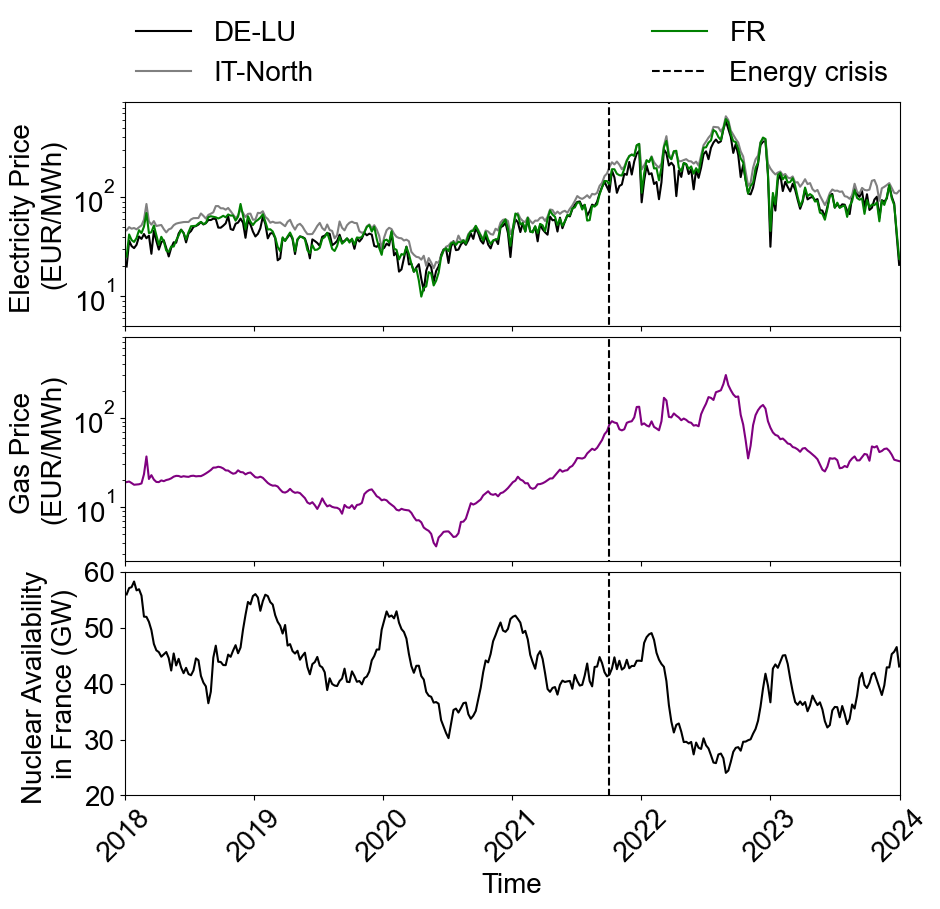

In [32]:
scale_font_latex(1)

colors = sns.color_palette("colorblind")


# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 9))

# Combined check for None and empty strings

ax1.plot(
    data.loc[:, "price_da_DE_LU"].resample("1W").mean().ffill(),
    color="black",
    label="DE-LU",
)
ax1.plot(
    data.loc[:, "price_da_IT_NORD"].resample("1W").mean().ffill(),
    color="gray",
    label="IT-North",
)
ax1.plot(
    data.loc[:, "price_da"].resample("1W").mean().ffill(), color="green", label="FR"
)
ax1.vlines(
    ENERGY_CRISIS,
    ymin=0,
    ymax=1000,
    colors="black",
    linestyles="--",
    label="Energy crisis",
)
ax1.set_ylabel("Electricity Price \n(EUR/MWh)")
ax1.set_ylim(5, 900)
ax1.set_yscale("log")
_ = plt.setp(
    ax1.xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor"
)
ax1.legend(
    loc="lower left",
    markerscale=6,
    ncol=2,
    frameon=False,
    bbox_to_anchor=(0.0, 1.02, 1.0, 0.102),
    mode="expand",
    borderaxespad=0.0,
)


ax2.plot(
    data.loc[:, "gas_price"].resample("1W").mean().ffill(), c="purple", label="EU gas"
)
ax2.vlines(
    ENERGY_CRISIS,
    ymin=0,
    ymax=1000,
    colors="black",
    linestyles="--",
    label="Energy crisis",
)
ax2.set_ylabel("Gas Price \n(EUR/MWh)")
ax2.set_ylim(2.5, 800)
ax2.set_yscale("log")
_ = plt.setp(
    ax2.xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor"
)
ax2.set_xlim(pd.to_datetime("2018-01-01"), pd.to_datetime("2023-12-31"))
_ = plt.xticks(rotation=45)


ax3.plot(
    data.loc[:, "nuclear_avail"].resample("1W").mean().ffill() / 1000,
    c="black",
    label="Nuclear availability",
)
ax3.vlines(
    ENERGY_CRISIS,
    ymin=0,
    ymax=1000,
    colors="black",
    linestyles="--",
    label="Energy crisis",
)
ax3.set_ylabel("Nuclear Availability \nin France (GW)")
ax3.set_xlabel("Time")
ax3.set_ylim(20, 60)
_ = plt.setp(
    ax2.xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor"
)
ax3.set_xlim(pd.to_datetime("2018-01-01"), pd.to_datetime("2023-12-31"))
_ = plt.xticks(rotation=45)
# Set specific years for the x-axis ticks
years = ["2018", "2019", "2020", "2021", "2022", "2023", "2024"]
year_dates = pd.to_datetime(years)

plt.xticks(year_dates, years)
# Adjust the space between subplots
plt.subplots_adjust(hspace=0.05)  # Set to 0 for no space

fig_dir = "../reports/figures/energy_crisis"
os.makedirs(fig_dir, exist_ok=True)
fig.savefig(fig_dir + f"/electricity_vs_gas_price.pdf", bbox_inches="tight")
plt.show()

## Plot European gas price dependency and price increase

In [ ]:
# compare import dependency with mean price
scale_font_latex(1.25)
# load zones from entsoe
true_start = pd.Timestamp("20180101", tz="UTC")
true_end = pd.Timestamp("20231231", tz="UTC")
year = "2020"
time = pd.Timestamp(
    year + "0101"
)  # is only used to get correct bidding zones at this time. does nothing with values
geo_df = load_zones(zones, time)
geo_df["el prod by gas/total el prod "] = convert_to_cc_index(
    el_prod_gas[year]
) / convert_to_cc_index(total_el_eurostat[year])
geo_df["mean_ratio"] = (
    price[ENERGY_CRISIS:true_end].mean() / price[true_start:ENERGY_CRISIS].mean()
)

print("Norwegian relative price increase:")
print(
    price.loc[ENERGY_CRISIS:true_end, "NO_2"].mean()
    / price.loc[true_start:ENERGY_CRISIS, "NO_2"].mean()
)
labels = [
    "Share of gas in electricity mix",
    r"$\left<Price_{during}\right> / \left<Price_{before}\right>$",
]
titles = ["(a)", "(b)", "(c)", "(d)"]
colors = [
    cmr.get_sub_cmap("Purples", 0.15, 1),
    cmr.get_sub_cmap(plt.get_cmap("Greens"), 0.1, 1),
]
y_coord = 0.9
coords = [(0.05, y_coord), (0.3, y_coord)]
ticks = [[0, 0.3, 0.58], [2, 3, 4]]
paths = [f"/gas_dependency.pdf", f"/electricity_price_europe.pdf"]
# sns.set_style("whitegrid")

fig_dir = "../reports/figures/energy_crisis"
os.makedirs(fig_dir, exist_ok=True)
# axes = [item for row in axes for item in row]
for i, label in enumerate(labels):
    fig, ax = plt.subplots(1, 1, figsize=(6, 9), layout="constrained")
    ax.set_axis_off()
    column_name = geo_df.columns[1 + i]
    vmin = geo_df[column_name].min()
    vmax = geo_df[column_name].max()
    sm = plt.cm.ScalarMappable(cmap=colors[i], norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []

    cb = plt.colorbar(sm, ax=ax, orientation="horizontal", pad=0.01, shrink=1)
    cb.set_label(label=labels[i], labelpad=-100)
    cb.set_ticks(ticks=ticks[i])

    geo_df.plot(
        column=column_name,
        legend=False,
        ax=ax,
        cmap=colors[i],
        missing_kwds={
            "color": "grey",
        },
    )
    ax.set_aspect(1.6724364168343848)

    fig.savefig(fig_dir + paths[i], bbox_inches="tight")
    plt.show()

### Share of gas in electricity generation

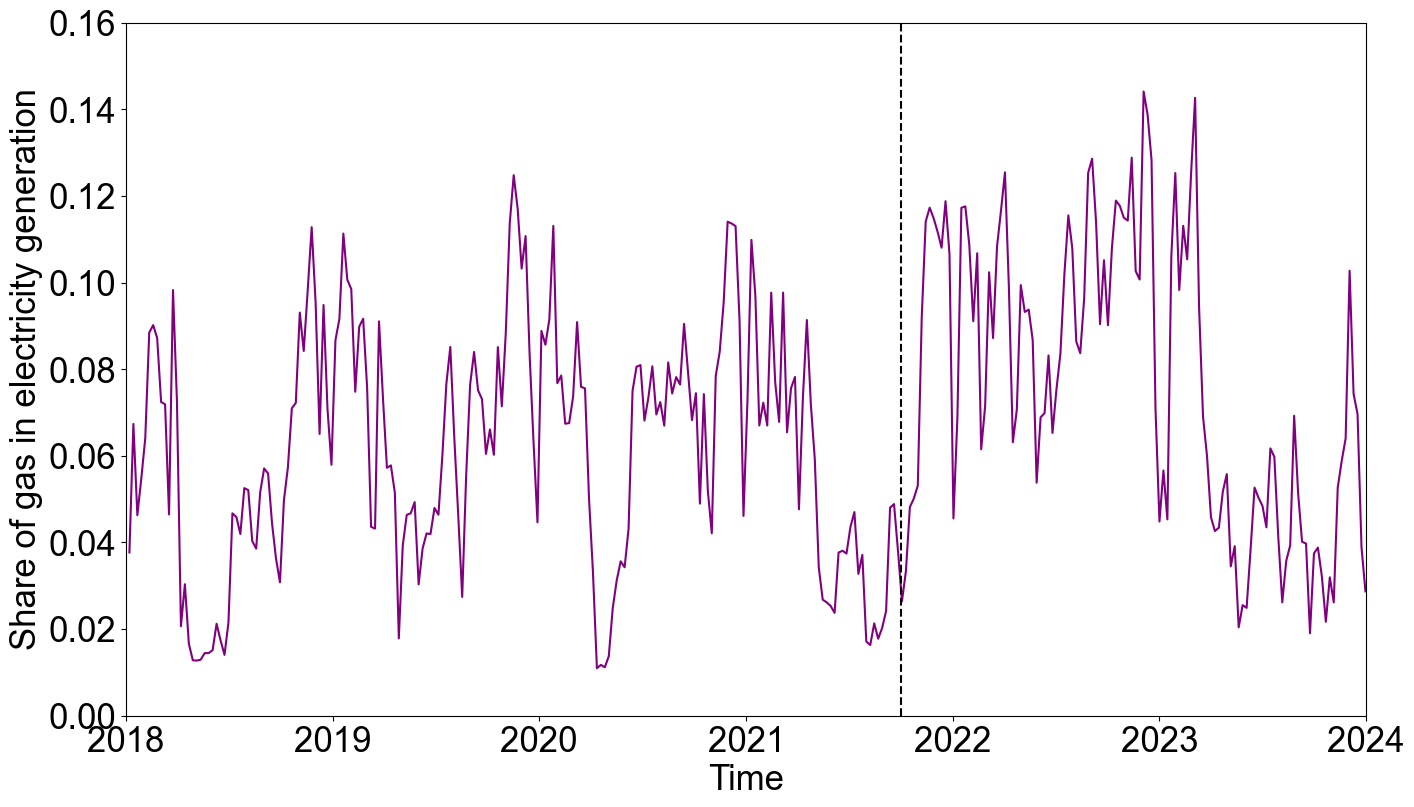

In [33]:
scale_font_latex(1.25)
fig = plt.figure(figsize=(16, 9))
gen_sum = data_full.filter(like="_gen").sum(axis=1)
share_of_gas_in_gen = data_full.loc[:, "gas_gen"] / gen_sum
plt.plot(
    share_of_gas_in_gen.resample("1W").mean().ffill(),
    c="purple",
    label="Gas generation",
)
plt.vlines(
    ENERGY_CRISIS,
    ymin=0,
    ymax=0.2,
    colors="black",
    linestyles="--",
    label="Energy crisis",
)
plt.ylabel("Share of gas in electricity generation")
plt.xlabel("Time")
plt.ylim(0, 0.16)
plt.xlim(pd.to_datetime("2018-01-01"), pd.to_datetime("2023-12-31"))
# Set specific years for the x-axis ticks
years = ["2018", "2019", "2020", "2021", "2022", "2023", "2024"]
year_dates = pd.to_datetime(years)

plt.xticks(year_dates, years)

fig.savefig(fig_dir + f"/share_of_gas_in_electricity_gen.pdf", bbox_inches="tight")
plt.show()

In [5]:
mean_price_oct_2021 = data.loc["2021-10-01":"2021-10-31", "price_da"].mean()
mean_price_year_before = data.loc["2020-10-01":"2021-10-01", "price_da"].mean()
print(f"Mean price in October 2021: {mean_price_oct_2021:.2f} EUR/MWh")
print(f"Mean price October 2020 - October 2021: {mean_price_year_before:.2f} EUR/MWh")

Mean price in October 2021: 172.54 EUR/MWh
Mean price October 2020 - October 2021: 64.20 EUR/MWh
